# Logistic Regression Classifier

The goal of this notebook is to classify our samples using a Logistic Regression model. We will attempt 3 different variations in terms of target variables.

1. Each individual accent
2. Consolidated accents (North, Mid, South, West)
3. Further consolidated regions (East, west)




In [1]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap


from sklearn.linear_model import LogisticRegression


In [2]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()

In [3]:
def average_speakers(mfcc_df):
    feature_cols = [x for x in mfcc_df.columns if 'feature' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'word'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined




def load_data():
    train = pd.read_csv('all_words_train_mfcc.csv')
    test = pd.read_csv('all_words_test_mfcc.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    test = test.loc[test.word.isin(train.word)].reset_index()
    
    train = average_speakers(train)
    
    british_df = pd.read_csv('british_mfcc.csv')
    feature_cols = [x for x in british_df.columns if 'feature' in x]
    
    return train, test, british_df[feature_cols]


train, test, british_df = load_data()

In [4]:
test.shape # 13596
print(british_df.shape)
test.loc[test['word'].isin(train['word'])].shape

(732, 12)


(10854, 18)

In [5]:
test.accent.value_counts()

DR4    2146
DR5    1923
DR3    1857
DR2    1826
DR7    1552
DR6     777
DR1     773
Name: accent, dtype: int64

In [6]:
def logistic_reg(train, test, display_conf=True, word=None, features = None, tune = False):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if 'feature' in x]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
    
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
    
    logit = LogisticRegression(max_iter = 1250)
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C)

    clf = GridSearchCV(logit, hyperparameters, cv=5, verbose=0)

    best_model = clf.fit(X_train, y_train)

    # View best hyperparameters
    print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
    print('Best C:', best_model.best_estimator_.get_params()['C'])
                           
    y_pred = best_model.predict(X_test)
    
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

    if display_conf:
        conf_mat = confusion_matrix(y_test, y_pred)
        plot_conf_matconf(conf_mat)
    
        print("Logistic Reg Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))    
        print(conf_df)
    
    
    return best_model, y_pred, conf_df





Best Penalty: l2
Best C: 1.0


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


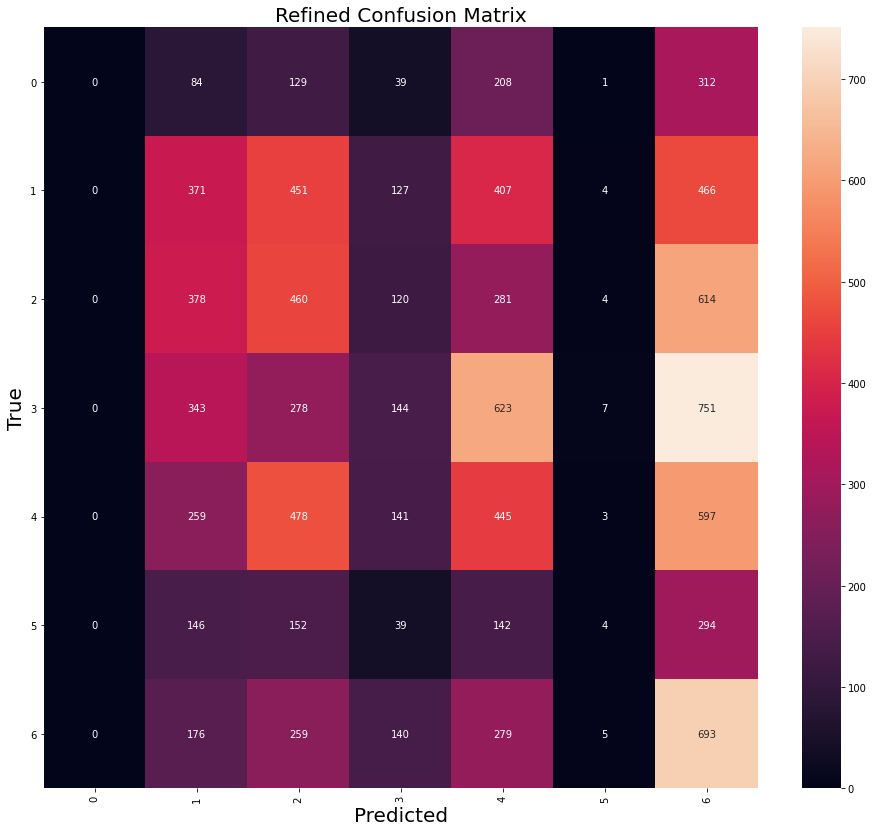

Logistic Reg Number of mislabeled points out of a total 10854 points : 8737
             DR1          DR2          DR3          DR4          DR5  \
precision    0.0     0.211155     0.208428     0.192000     0.186583   
recall       0.0     0.203176     0.247711     0.067102     0.231409   
f1-score     0.0     0.207089     0.226378     0.099448     0.206592   
support    773.0  1826.000000  1857.000000  2146.000000  1923.000000   

                  DR6          DR7  accuracy     macro avg  weighted avg  
precision    0.142857     0.185940  0.195043      0.160995      0.179015  
recall       0.005148     0.446521  0.195043      0.171581      0.195043  
f1-score     0.009938     0.262550  0.195043      0.144571      0.168087  
support    777.000000  1552.000000  0.195043  10854.000000  10854.000000  


In [7]:
logit_whole, logit_y_pred_whole, logit_conf_whole = logistic_reg(train, test)


In [ ]:
british_pred = logit_whole.predict(british_df)

In [ ]:
whole_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

whole_pred['pred_tally'] = 1

print(whole_pred['pred_accent'].value_counts())


whole_bp = whole_pred.groupby('pred_accent').sum()
whole_bp['pred_percent'] = whole_bp['pred_tally'] / whole_bp['pred_tally'].sum() * 100.00

whole_bp.head(10)

In [ ]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test


In [ ]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_test.accent.value_counts()

In [ ]:
logit_condensed, logit_y_pred_condensed, logit_conf_condensed = logistic_reg(condensed_train, condensed_test)


In [ ]:
british_pred = logit_condensed.predict(british_df)


condensed_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

condensed_pred['pred_tally'] = 1

print(condensed_pred['pred_accent'].value_counts())


condensed__sum = condensed_pred.groupby('pred_accent').sum()
condensed__sum['pred_percent'] = condensed__sum['pred_tally'] / condensed__sum['pred_tally'].sum() * 100.00

condensed__sum.head(10)


In [ ]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'West',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

In [ ]:
logit_cm, logit_y_pred_cm, logit_conf_cm = logistic_reg(condensed_train_two_regions, condensed_tes_two_regions)


In [ ]:
british_pred = logit_cm.predict(british_df)


cm_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

cm_pred['pred_tally'] = 1

print(cm_pred['pred_accent'].value_counts())


cm_pred__sum = cm_pred.groupby('pred_accent').sum()
cm_pred__sum['pred_percent'] = cm_pred__sum['pred_tally'] / cm_pred__sum['pred_tally'].sum() * 100.00

cm_pred__sum.head(10)